## 0-背景
通过电影打分数据集movielens介绍电影推荐算法，在我们的生活中，或多或少都用过爱奇艺、优酷、腾讯视频看看电影、综艺或者电视剧等，在不经意间留下了很多自己的信息，包括注册时的用户属性信息、点击、观看、收藏、转发、评论、评分、弹幕等行为数据。通过这些数据，推荐系统可以更了解你，不断吸引你留在APP里面“消费”。

通过本节，你可以学会使用TensorFlow和TensorFlow ranking开发推荐算法，包括：
1. 数据探索；
2. 数据流构建；
2. 模型定义；
3. 模型训练；
4. 模型评价；

让我们一起踏上推荐算法的学习之旅吧。

## 1-准备

Python在运行之前首先要安装并导入必要的包，这些包既可以是开源的，也可以是自己打包好的，正如前面所说，我们要安装tensorflow，这是目前最流行的深度学习开发框架，tensorflow_ranking正是基于tensorflow开发的推荐算法包。

In [1]:
!pip install numpy==1.19.5
!pip install pandas==1.1.5
!pip install seaborn==0.11.2
!pip install tensorflow_ranking==0.5.0
!pip install tensorflow-datasets==4.0.1

     |████████████████████████████████| 141 kB 4.8 MB/s 


In [2]:
import warnings 
warnings.filterwarnings('ignore')
import numpy as np 
import pandas as pd
import seaborn as sns 
from collections import Counter
import matplotlib.pyplot as plt
import tensorflow as tf 
import tensorflow_ranking as tfr
import tensorflow_datasets as tfds

## 2-数据探索
我们在进行数据算法开发的时候，第一步必须要分析一下数据，数据质量和数据规律会影响我们成功的先决条件。

In [3]:
# 下载数据
rating = tfds.load('movielens/100k-ratings', split="train")
movie = tfds.load('movielens/100k-movies', split="train")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/movielens/100k-ratings/0.1.0.incompleteDVUAVY/movielens-train.tfrecord


  0%|          | 0/100000 [00:00<?, ? examples/s]

Dataset movielens downloaded and prepared to /root/tensorflow_datasets/movielens/100k-ratings/0.1.0. Subsequent calls will reuse this data.


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/movielens/100k-movies/0.1.0.incompleteNW82SA/movielens-train.tfrecord


  0%|          | 0/1682 [00:00<?, ? examples/s]

Dataset movielens downloaded and prepared to /root/tensorflow_datasets/movielens/100k-movies/0.1.0. Subsequent calls will reuse this data.


将数据转化成dataframe，便于分析

In [4]:
df_rating = tfds.as_dataframe(rating) 
df_movie = tfds.as_dataframe(movie) 

打分数据，共计12个字段，介绍了用户的性别、年龄、职业和打分等数据，这些数据用一个专业的描述就是特征，我们记住在数据算法的视角里，万物皆特征。

In [5]:
df_rating.info()   

<class 'tensorflow_datasets.core.as_dataframe.StyledDataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 12 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   bucketized_user_age    100000 non-null  float64
 1   movie_genres           100000 non-null  object 
 2   movie_id               100000 non-null  object 
 3   movie_title            100000 non-null  object 
 4   raw_user_age           100000 non-null  float64
 5   timestamp              100000 non-null  int64  
 6   user_gender            100000 non-null  bool   
 7   user_id                100000 non-null  object 
 8   user_occupation_label  100000 non-null  int64  
 9   user_occupation_text   100000 non-null  object 
 10  user_rating            100000 non-null  float64
 11  user_zip_code          100000 non-null  object 
dtypes: bool(1), float64(3), int64(2), object(6)
memory usage: 8.5+ MB


我们其实比较关注用户打分数据的合理性，所以可以看下统计指标，可见打分数据基本上是1-5分，这是符合期望的。

In [6]:
df_rating.describe() 

,bucketized_user_age,raw_user_age,timestamp,user_occupation_label,user_rating
count,100000.000000,100000.000000,1.000000e+05,100000.000000,100000.000000
mean,29.235460,32.969850,8.835289e+08,11.404320,3.529860
std,12.005927,11.562623,5.343856e+06,6.549283,1.125674
min,1.000000,7.000000,8.747247e+08,0.000000,1.000000
25%,18.000000,24.000000,8.794487e+08,6.000000,3.000000
50%,25.000000,30.000000,8.828269e+08,12.000000,4.000000
75%,35.000000,40.000000,8.882600e+08,17.000000,4.000000
max,56.000000,73.000000,8.932866e+08,21.000000,5.000000


In [7]:
df_movie.info() 

<class 'tensorflow_datasets.core.as_dataframe.StyledDataFrame'>
RangeIndex: 1682 entries, 0 to 1681
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   movie_genres  1682 non-null   object
 1   movie_id      1682 non-null   object
 2   movie_title   1682 non-null   object
dtypes: object(3)
memory usage: 39.5+ KB


In [8]:
# 用户数量
df_rating.user_id.nunique() 

943

In [9]:
# 电影数量
df_rating.movie_title.nunique() 

1664

In [10]:
df_rating['age_group'] = df_rating.raw_user_age.apply(
    lambda age: 'child' if 0<=age<=12 else ('teenager' if 13<=age<=19 else (
        'young' if 20<=age<=35 else ('midlife' if 36<=age<=55 else 'old'))))
df_rating.loc[df_rating.user_gender==True, 'user_gender'] = 'male'
df_rating.loc[df_rating.user_gender==False, 'user_gender'] = 'female'
df_rating['user_occupation_text'] = df_rating['user_occupation_text'].str.decode('utf-8') 

In [11]:
# 评分分布
df_rating.groupby('user_rating').size()/ df_rating['user_rating'].count() 

user_rating
1.0    0.06110
2.0    0.11370
3.0    0.27145
4.0    0.34174
5.0    0.21201
dtype: float64

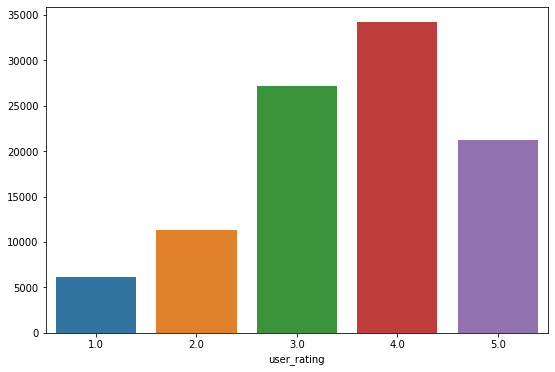

In [12]:
plt.figure(figsize=(9,6))
sns.barplot(df_rating.groupby('user_rating').size().index, df_rating.groupby('user_rating').size().values)

可以发现，如果3分认为是一般的话，评分数据的分布还是比较均匀的，一般及较差、很差的占比达到40%

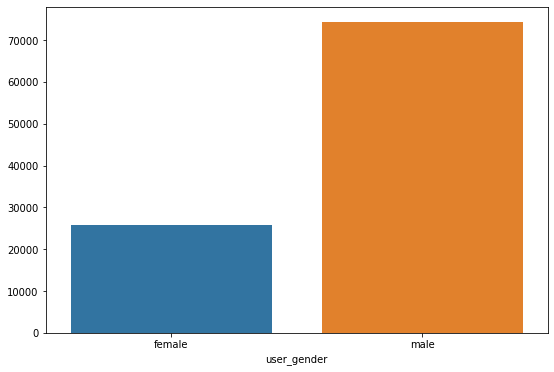

In [13]:
plt.figure(figsize=(9,6))
sns.barplot(df_rating.groupby('user_gender').size().index, df_rating.groupby('user_gender').size().values)

可以发现，男性比女性的评分多，这只是一个现象，如果我们有其它数据支撑的话，可以进一步结合男性和女性用户的数量分析性别对打分行为有没有显著影响。

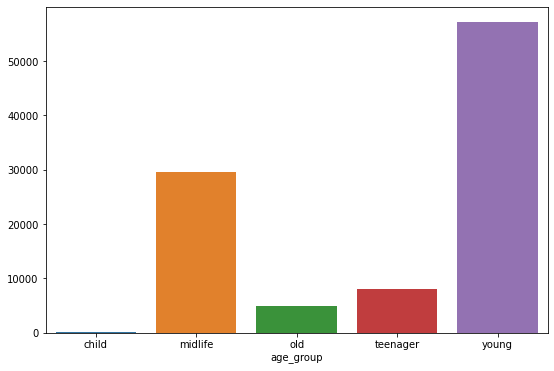

In [14]:
plt.figure(figsize=(9,6))
sns.barplot(df_rating.groupby('age_group').size().index, df_rating.groupby('age_group').size().values)

可以发现，年轻人和中年人的评分比较多，同理这也只是一个现象，如果我们有其它数据支撑的话，可以进一步结合不同年龄段用户的数量分析年龄对打分行为有没有显著影响。

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20]), <a list of 21 Text major ticklabel objects>)

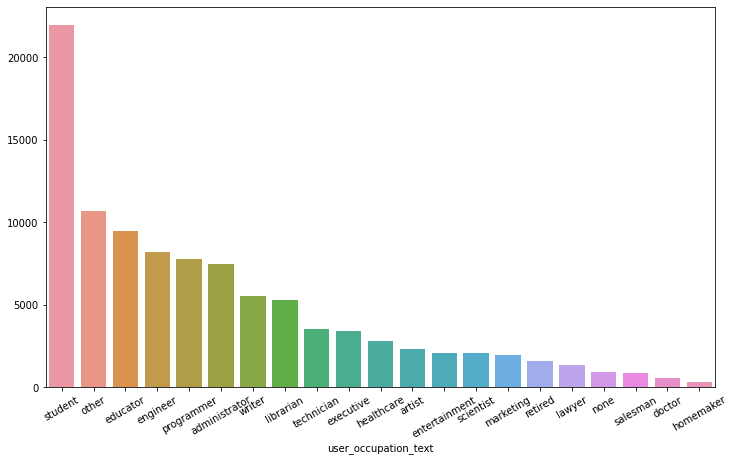

In [15]:
plt.figure(figsize=(12,7))
user_occupation = df_rating.groupby('user_occupation_text').size().sort_values(ascending=False)
sns.barplot(user_occupation.index, user_occupation.values)
plt.xticks(rotation=30)

可以发现，学生是评分最多的职业，结合刚刚的年龄不难发现，年轻人里面有一部分是在校的学生，还有一部分是毕业的工作者。

In [16]:
df_rating.groupby(['user_occupation_text', 'age_group']).size().sort_values(ascending=False)

user_occupation_text  age_group
student               young        14507
                      teenager      6998
other                 young         6800
programmer            young         5592
educator              midlife       4907
                                   ...  
salesman              teenager        32
doctor                old             31
none                  child           27
healthcare            old             23
none                  midlife         20
Length: 62, dtype: int64

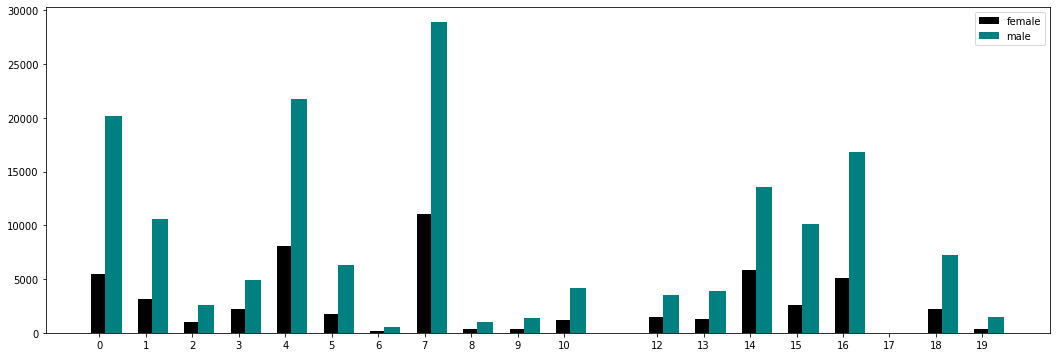

In [17]:
plt.figure(figsize=(18, 6))
df_rating['exist_num'] = df_rating['movie_genres'].map(Counter)
female_genre, female_num = zip(*df_rating.groupby(['user_gender'])['exist_num'].sum().to_dict()['female'].items())
plt.bar(female_genre, female_num, width = 0.35, color='black', label="female")
male_genre, male_num = zip(*df_rating.groupby(['user_gender'])['exist_num'].sum().to_dict()['male'].items())
plt.bar([x+0.3 for x in male_genre], male_num, width = 0.35, color='teal', label="male")
plt.xticks(female_genre, [str(x) for x in female_genre])  
plt.legend()
plt.show()

可以发现，7、0和4是用户评分最多的电影类型，同理这也是一个现象，如果我们有其它数据支撑的话，可以分析电影类型对用户评分行为有没有显著影响。

## 3-数据流构建

简单起见，我们只利用用户ID和电影名称作为特征、评分作为标记构建数据流，那么还有很多其他特征感兴趣的同学可以进一步尝试。

In [18]:
# 取到我们需要的两个特征：用户ID和电影名称；以及标记数据
movies = movie.map(lambda x: x["movie_title"])
users = rating.map(lambda x: x["user_id"])
rating = rating.map(lambda x: {
    "movie_title": x["movie_title"],
    "user_id": x["user_id"],
    "user_rating": x["user_rating"]
})
# 构建用户ID字典
user_id_vocabulary = tf.keras.layers.experimental.preprocessing.StringLookup(
    mask_token=None)
user_id_vocabulary.adapt(users.batch(1000))
# 构建电影名称字典
movie_title_vocabulary = tf.keras.layers.experimental.preprocessing.StringLookup(
    mask_token=None)
movie_title_vocabulary.adapt(movies.batch(1000))

In [19]:
# 电影名称字典
movie_title_vocabulary.get_vocabulary()[:10] 

['[UNK]',
 "Ulee's Gold (1997)",
 'That Darn Cat! (1997)',
 'Substance of Fire, The (1996)',
 'Sliding Doors (1998)',
 'Nightwatch (1997)',
 'Money Talks (1997)',
 'Kull the Conqueror (1997)',
 'Ice Storm, The (1997)',
 'Hurricane Streets (1998)']

In [20]:
# 查电影名称字典的例子
test_ds = tf.data.Dataset.from_tensor_slices(['Nightwatch (1997)',
                                               'Money Talks (1997)',
                                               'Kull the Conqueror (1997)',
                                               'Ice Storm, The (1997)',
                                               'Beauty and the Beast(2017)'])
lookup_ds = test_ds.map(movie_title_vocabulary)
list(lookup_ds.as_numpy_iterator())

[5, 6, 7, 8, 0]

因为电影推荐是对用户而言的，所以需要按照用户ID分组，在同组内的比较电影才有意义。

In [21]:
key_func = lambda x: user_id_vocabulary(x["user_id"])
reduce_func = lambda key, dataset: dataset.batch(100)
ds = rating.group_by_window(
    key_func=key_func, reduce_func=reduce_func, window_size=100)

In [22]:
for x in ds.take(1):
  for key, value in x.items():
    print(f"Shape of {key}: {value.shape}")
    print(f"Example values of {key}: {value[:8].numpy()}")
    print()

Shape of movie_title: (100,)
Example values of movie_title: [b'Man Who Would Be King, The (1975)' b'Silence of the Lambs, The (1991)'
 b'Next Karate Kid, The (1994)' b'2001: A Space Odyssey (1968)'
 b'Usual Suspects, The (1995)' b'Critical Care (1997)'
 b'Annie Hall (1977)' b'Manhattan (1979)']

Shape of user_id: (100,)
Example values of user_id: [b'405' b'405' b'405' b'405' b'405' b'405' b'405' b'405']

Shape of user_rating: (100,)
Example values of user_rating: [1. 4. 1. 5. 5. 1. 1. 3.]



In [23]:
def _features_and_labels(x):
  labels = x.pop("user_rating")
  return x, labels


ds = ds.map(_features_and_labels)

ds = ds.apply(
    tf.data.experimental.dense_to_ragged_batch(batch_size=32))

In [24]:
for x, label in ds.take(1):
  for key, value in x.items():
    print(f"Shape of {key}: {value.shape}")
    print(f"Example values of {key}: {value[:3, :3].numpy()}")
    print()
  print(f"Shape of label: {label.shape}")
  print(f"Example values of label: {label[:3, :3].numpy()}")

Shape of movie_title: (32, None)
Example values of movie_title: [[b'Man Who Would Be King, The (1975)'
  b'Silence of the Lambs, The (1991)' b'Next Karate Kid, The (1994)']
 [b'Flower of My Secret, The (Flor de mi secreto, La) (1995)'
  b'Little Princess, The (1939)' b'Time to Kill, A (1996)']
 [b'Kundun (1997)' b'Scream (1996)' b'Power 98 (1995)']]

Shape of user_id: (32, None)
Example values of user_id: [[b'405' b'405' b'405']
 [b'655' b'655' b'655']
 [b'13' b'13' b'13']]

Shape of label: (32, None)
Example values of label: [[1. 4. 1.]
 [3. 3. 3.]
 [5. 1. 1.]]


In [25]:
ds_train = ds.take(40)
ds_val = ds.skip(40).take(8)

## 4-模型定义

In [26]:
class simple_matrix_factorization(tf.keras.Model):

  def __init__(self, user_vocab, movie_vocab):
    super().__init__()

    self.user_vocab = user_vocab
    self.movie_vocab = movie_vocab
    self.user_embed = tf.keras.layers.Embedding(user_vocab.vocabulary_size(), 18)
    self.movie_embed = tf.keras.layers.Embedding(movie_vocab.vocabulary_size(), 18)

  def call(self, features):

    user_embeddings = self.user_embed(self.user_vocab(features["user_id"]))
    movie_embeddings = self.movie_embed(
        self.movie_vocab(features["movie_title"]))

    return tf.reduce_sum(user_embeddings * movie_embeddings, axis=2)

In [32]:
model = simple_matrix_factorization(user_id_vocabulary, movie_title_vocabulary)
optimizer = tf.keras.optimizers.Adagrad(0.5)
loss = tfr.keras.losses.get(
    loss=tfr.keras.losses.RankingLossKey.SOFTMAX_LOSS, ragged=True)
eval_metrics = tfr.keras.metrics.get(key="ndcg", name="metric/ndcg", topn=3, ragged=True)
model.compile(optimizer=optimizer, loss=loss, metrics=eval_metrics)

## 5-模型训练

In [33]:
model.fit(ds_train, validation_data=ds_val, epochs=2)

Epoch 1/2
40/40 [==============================] - 15s 271ms/step - loss: 1135.5945 - metric/ndcg: 0.5106 - val_loss: 295.4186 - val_metric/ndcg: 0.5103
Epoch 2/2
40/40 [==============================] - 16s 379ms/step - loss: 1134.5039 - metric/ndcg: 0.7307 - val_loss: 295.4221 - val_metric/ndcg: 0.5049


In [39]:
model.summary()  

Model: "simple_matrix_factorization_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 string_lookup (StringLookup  multiple                 0         
 )                                                               
                                                                 
 string_lookup_1 (StringLook  multiple                 0         
 up)                                                             
                                                                 
 embedding_2 (Embedding)     multiple                  16992     
                                                                 
 embedding_3 (Embedding)     multiple                  29970     
                                                                 
Total params: 46,962
Trainable params: 46,962
Non-trainable params: 0
_________________________________________________________________


## 6-模型评价

In [ ]:
for x, label in ds_val.take(1):
  for key, value in x.items():
    print(f"Shape of {key}: {value.shape}")
    print(f"Example values of {key}: {value[:3, :3].numpy()}")
    print()
  print(f"Shape of label: {label.shape}")
  print(f"Example values of label: {label[:3, :3].numpy()}")
test_user = value.numpy()[0][0].decode('utf-8') 

Shape of movie_title: (32, None)
Example values of movie_title: [[b'Rock, The (1996)' b'Contact (1997)' b'Apostle, The (1997)']
 [b'Ace Ventura: Pet Detective (1994)' b'Courage Under Fire (1996)'
  b'Men in Black (1997)']
 [b'Peacemaker, The (1997)' b'G.I. Jane (1997)'
  b'Midnight in the Garden of Good and Evil (1997)']]

Shape of user_id: (32, None)
Example values of user_id: [[b'564' b'564' b'564']
 [b'337' b'337' b'337']
 [b'29' b'29' b'29']]

Shape of label: (32, None)
Example values of label: [[4. 4. 4.]
 [4. 5. 3.]
 [3. 2. 4.]]


In [ ]:
for movie_titles in movies.batch(5000):
  break

test_case = {
    "user_id":
        tf.expand_dims(tf.repeat(f"{test_user}", repeats=movie_titles.shape[0]), axis=0),
    "movie_title":
        tf.expand_dims(movie_titles, axis=0)
}

scores = model(test_case)
titles = tfr.utils.sort_by_scores(scores,
                                  [tf.expand_dims(movie_titles, axis=0)])[0]
print(f"Top 10 recommendations for user {test_user}: {titles[0, :10]}")

Top 10 recommendations for user 564: [b'Before Sunrise (1995)' b'Star Trek: The Motion Picture (1979)'
 b'Sliver (1993)' b'Mixed Nuts (1994)' b'Playing God (1997)'
 b'Jingle All the Way (1996)' b'Love & Human Remains (1993)'
 b'Sum of Us, The (1994)' b'In the Army Now (1994)'
 b'When a Man Loves a Woman (1994)']


In [ ]:
df_rating[(df_rating.user_id==test_user.encode())][['user_id',
                                                    'movie_title',
                                                    'user_rating']].sort_values('user_rating', ascending=False)

,user_id,movie_title,user_rating
1284,b'564',"b'Rock, The (1996)'",4.0
33876,b'564',b'Rosewood (1997)',4.0
97998,b'564',b'Titanic (1997)',4.0
94267,b'564',b'Eraser (1996)',4.0
83106,b'564',b'Evita (1996)',4.0
77810,b'564',"b'Godfather, The (1972)'",4.0
61909,b'564',b'Star Wars (1977)',4.0
1291,b'564',b'Contact (1997)',4.0
46226,b'564',"b""Devil's Own, The (1997)""",4.0
41453,b'564',b'Men in Black (1997)',4.0


In [ ]:
df_rating[(df_rating.user_id==test_user.encode())&(
    df_rating.movie_title.isin(titles[0, :10].numpy()))][['user_id', 'movie_title', 'user_rating']]  

,user_id,movie_title,user_rating
